In [1]:
import qiskit
import numpy
from itertools import permutations 
from qiskit.visualization import plot_gate_map, plot_circuit_layout, plot_histogram
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.transpiler import CouplingMap
%matplotlib inline

provider = IBMQ.load_account()

In [2]:
def generate_circuit_complete(n_qubits):
    A = numpy.ones((n_qubits, n_qubits))
    return qiskit.circuit.library.GraphState(A)

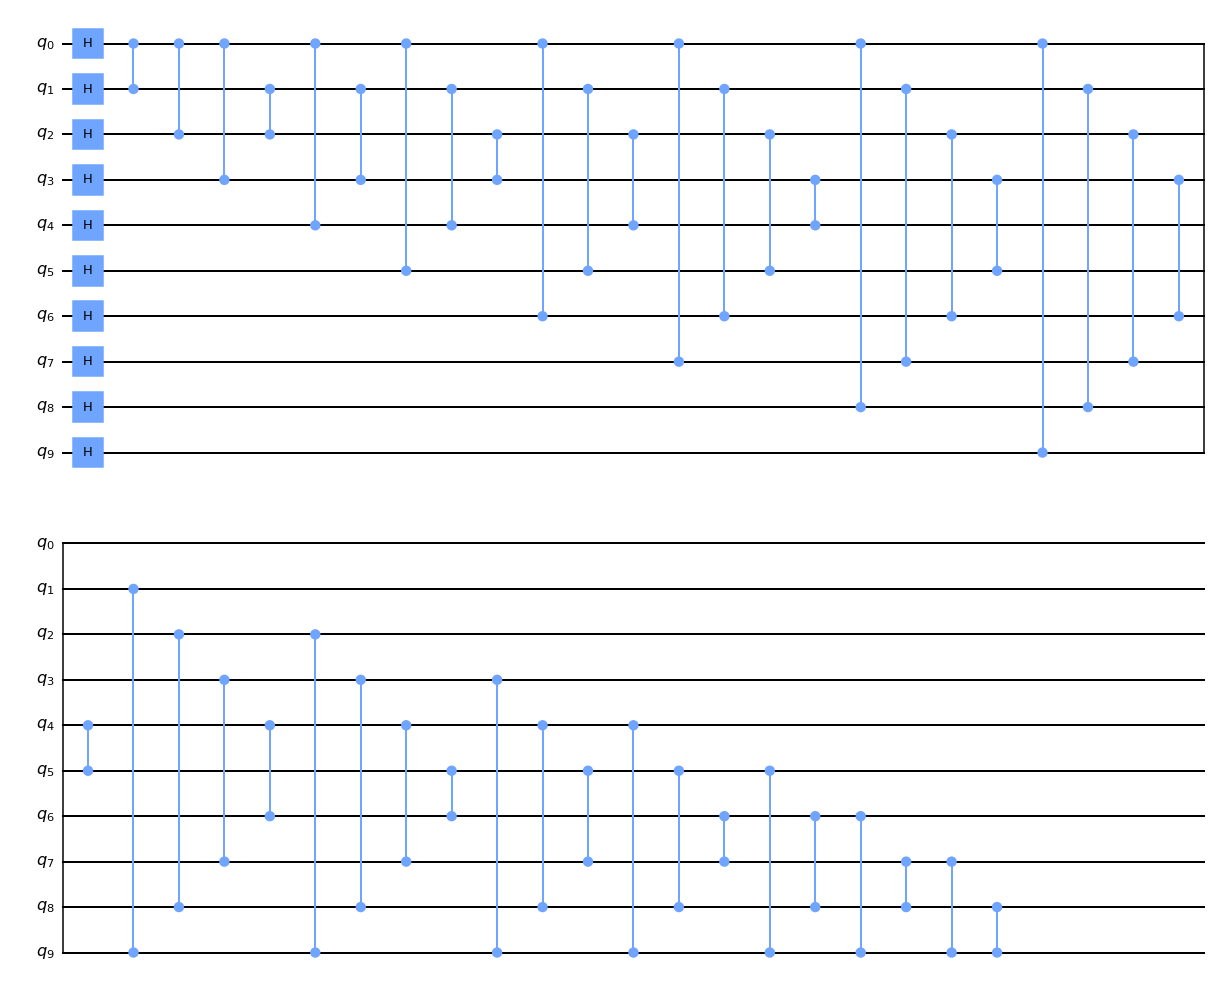

In [3]:
generate_circuit_complete(10).draw('mpl')

In [4]:
def generate_circuit_complete(n_qubits):
    # TODO only once CNOT per pair
    qc = QuantumCircuit(n_qubits)
    perm = permutations(range(n_qubits), 2)  
    for i in perm:  
        qc.cx(i[0], i[1])
    return qc

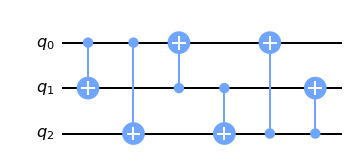

In [5]:
generate_circuit_complete(3).decompose().draw('mpl')

In [6]:
from qiskit.transpiler.passes import CSPLayout

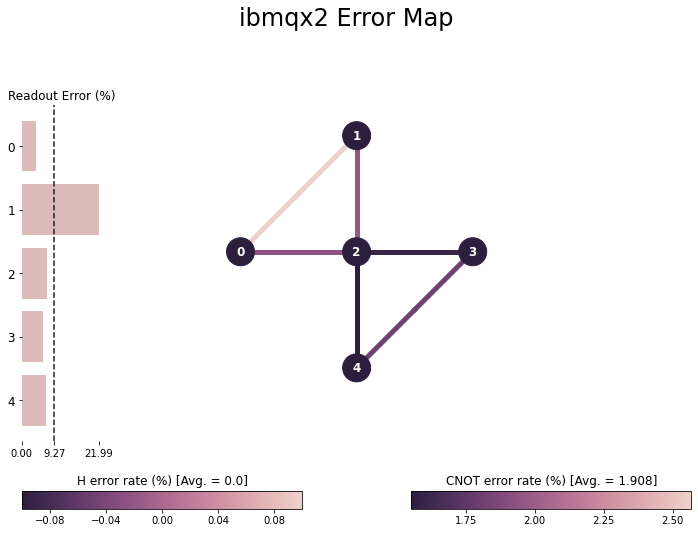

In [7]:
from qiskit.visualization.gate_map import plot_error_map
backend = provider.get_backend('ibmqx2')
plot_error_map(backend)

In [8]:
def run_layout_selector_on_circuit(circuit, layout_selector, backend, **kwargs):
    pass_ = layout_selector(CouplingMap(backend.configuration().coupling_map), **kwargs)
    property_set = {}
    pass_(circuit, property_set)
    circuit._layout = property_set['layout']
    return circuit

def layout_on_circuit(circuit, layout_selector, backend, **kwargs):
    circuit = run_layout_selector_on_circuit(circuit, layout_selector, backend, **kwargs)
    return plot_circuit_layout(circuit, backend)

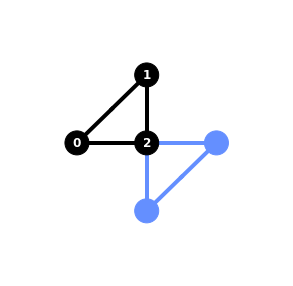

In [9]:
circuit = generate_circuit_complete(3)
layout_on_circuit(circuit, CSPLayout, backend, seed=42)

In [10]:
def generate_circuit_sub_coupling_map(coupling_map, list_of_physical_qubits):
    cm = backend.configuration().coupling_map
    def elected_edges(edge):
        if edge[0] not in list_of_physical_qubits:
            return False
        if edge[1] not in list_of_physical_qubits:
            return False
        return True

    rows = [list_of_physical_qubits.index(x[0]) for x in filter(elected_edges, cm)]
    cols = [list_of_physical_qubits.index(x[1]) for x in filter(elected_edges, cm)]

    n_qubits = len(list_of_physical_qubits)
    A = numpy.zeros((n_qubits, n_qubits))
    A[rows, cols] = 1

    qc = qiskit.circuit.library.GraphState(A)
    
    qc.measure_all()
    return qc

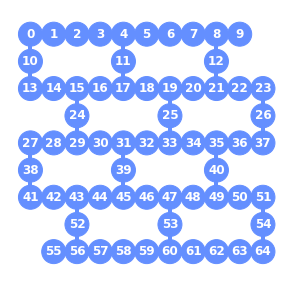

In [11]:
from qiskit.test.mock.backends import FakeManhattan
backend = FakeManhattan()
plot_gate_map(backend)

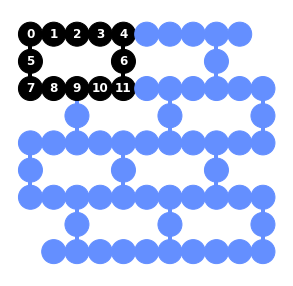

In [33]:
circuit = generate_circuit_sub_coupling_map(backend.configuration().coupling_map, [0,1,2,3,4,10,11,13,14,15,16,17])
# circuit = generate_circuit_sub_coupling_map(backend.configuration().coupling_map, [0,1])
# display(circuit.draw('mpl'))
layout_on_circuit(circuit, CSPLayout, backend, seed=34000)

In [13]:
from qiskit.providers.aer import QasmSimulator

def evaluate(circuit, layout_selector, backend='ideal', **kwargs):
    if backend == 'ideal':
        simulator = QasmSimulator()
    else:
        circuit = run_layout_selector_on_circuit(circuit, CSPLayout, backend, **kwargs)
        simulator = QasmSimulator.from_backend(backend)
    return execute(circuit, simulator, shots=8192).result()

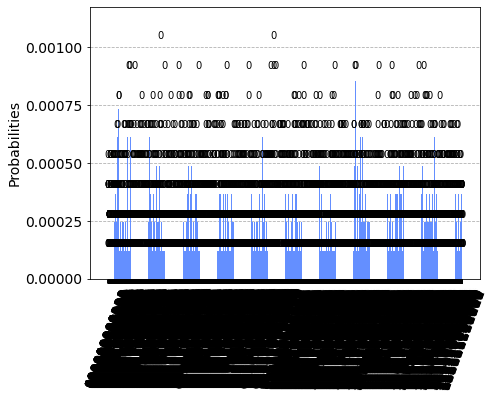

In [14]:
ideal_result = evaluate(circuit, CSPLayout, backend='ideal', seed=42)
plot_histogram(ideal_result.get_counts())

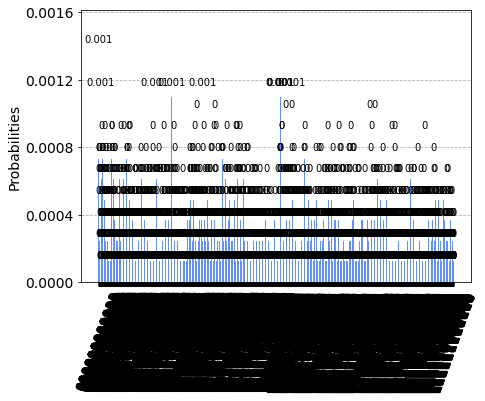

In [15]:
noise_result = evaluate(circuit, CSPLayout, backend=backend, seed=42)
plot_histogram(noise_result.get_counts())

In [17]:
ideal_counts = ideal_result.get_counts()
for noise_count in noise_result.get_counts():
    if noise_count not in ideal_counts:
        ideal_counts[noise_count] = 0
        
noise_counts = noise_result.get_counts()
for ideal_count in ideal_result.get_counts():
    if ideal_count not in noise_counts:
        noise_counts[ideal_count] = 0

In [20]:
import math
def hellinger(p, q):
    """Hellinger distance between two discrete distributions."""
    list_of_squares = []
    for p_i, q_i in zip(p, q):

        # caluclate the square of the difference of ith distr elements
        s = (math.sqrt(p_i) - math.sqrt(q_i)) ** 2
        
        # append 
        list_of_squares.append(s)
    
    # calculate sum of squares
    sosq = sum(list_of_squares)    
    
    return math.sqrt(sosq / 2)

In [30]:
def tvd(p, q):
    """total variation distance"""
    list_of_diffs = []
    for p_i, q_i in zip(p, q):
        list_of_diffs.append(abs(p_i-q_i))
    return sum(list_of_diffs)/2

In [31]:
hellinger(ideal_counts.values(), noise_counts.values())

26.341908329320322

In [32]:
tvd(ideal_counts.values(), noise_counts.values())

2522.0